In [2]:
import torch
import pandas as pd
from pathlib import Path
import h5py
import json
import numpy as np
from PIL import Image
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModelForCausalLM

/root/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 从image path list中加载image
def load_images_from_paths(paths):
    images = []
    for path in paths:
        images.append(Image.open(path).convert('RGB'))
    return images

In [4]:
# 1 加载模型
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda:0")

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[INST]  
 
 
 
You are a professional short film editor and director. I will give you some frames of a short video. Please score the frames based on their representativeness, diversity, and interest on a scale from 0 to 1. You may need to refer to the context for rating. You need to anwser how many frames i give to you. Describe the content of the frame first and then give the score. And give the final score list like `[scores]`. Try not to give the same score and use the format below.
Format:
 Frame 0: content of frame 0.
 Frame 0 Score: your score.
 Score List: []
Frame 0Frame 1Frame 2Frame 3 [/INST] Frame 0: The image shows a close-up of a person's face, with a focus on the eyes and mouth. The person appears to be middle-aged with graying hair and a mustache. The expression is neutral, and the person is looking directly at the camera.

Frame 0 Score: 0.5
Score List: [0.5]

Frame 1: The frame shows a close-up of a person's hand holding a small object, which appears to be a tool or a 

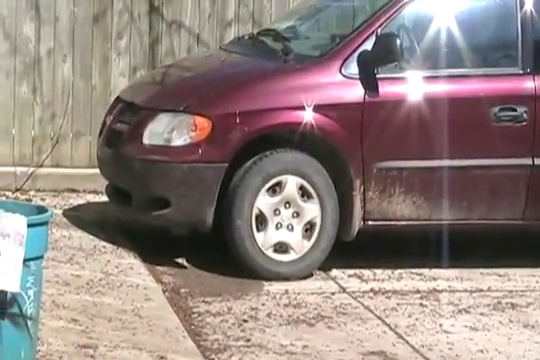

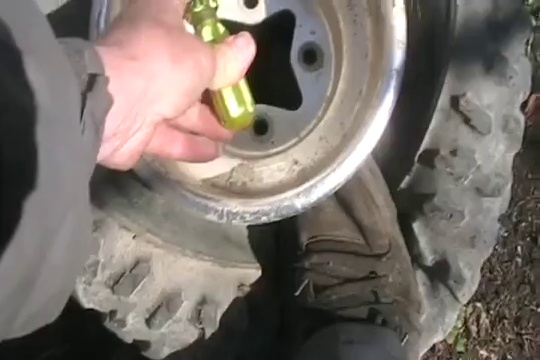

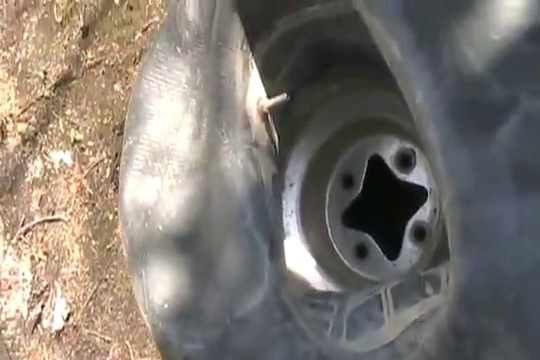

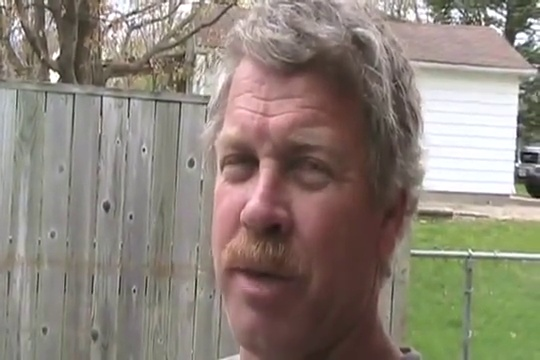

In [23]:
test_data = Path("/root/TFVSN/dataset/TVSum/tvsum_dataset_jump.json")
# 使用pandas打开

df = pd.read_json(test_data)
# 选择第一行转换为dict
data = df.iloc[105].to_dict()
images = data["images"]
conversation = data["conversation"]
images_list = load_images_from_paths(images)

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=images_list, text=prompt, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=700)
print(processor.decode(output[0], skip_special_tokens=True))
display(images_list[0])
display(images_list[1])
display(images_list[2])
display(images_list[3])
